In this notebook, we aim to do the following: 
1. Harvest the dataset with median instead of average because there may be outliers. (done) 
2. Drop the columns that correspond to AC because it will always be there. (done)
2. Get base scores without splitting the dataset. The scores we are interested in are AUC, PR AUC, Precision and Recall. (done)
3. Split the Training dataset manually using gene_id (done)
4. Perform Optimization using RandomizedSearchCV and then followed by gridsearchCV. (can't be done)
5. See how much better we can get with hyperparameter tuning. 
6. We shall then focus on reducing features and see if results improve. 

In [70]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, mean_squared_error, auc, roc_curve, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from scipy.stats import pearsonr, chi2_contingency, entropy
from scipy import special 
import seaborn as sns
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler

In [2]:
df = pd.read_json('./data/data.json', lines=True)
labels = pd.read_csv('./data/labels.info', sep=',')

We shall be taking median instead of mean because if there are outliers, the median is closer to the true value of the mean. 

In [3]:
def get_dataframe(df):
    transcripts = df.columns
    dataframes = []
    for transcript in transcripts:
        df_curr_transcript = df.loc[:, transcript]
        df_curr_transcript.dropna(inplace=True)
        df_curr_transcript = list(df_curr_transcript)
        
        for position in df_curr_transcript:
            #position here is a dictionary
            for k1, v1, in position.items():
                order = list(v1.keys())[0]
                for k2, v2 in v1.items():

                    
                    n = len(v2)

                    left_dwelling_t = np.zeros(n)
                    left_sd = np.zeros(n)
                    left_mean = np.zeros(n)

                    centre_dwelling_t = np.zeros(n)
                    centre_sd = np.zeros(n)
                    centre_mean = np.zeros(n)

                    right_dwelling_t = np.zeros(n)
                    right_sd = np.zeros(n)
                    right_mean = np.zeros(n)

                    for i in range(n):
                        left_dwelling_t[i] = v2[i][0]
                        left_sd[i] = v2[i][1]
                        left_mean[i] = v2[i][2]

                        centre_dwelling_t[i] = v2[i][3]
                        centre_sd[i] = v2[i][4]
                        centre_mean[i] = v2[i][5]
                        
                        right_dwelling_t[i] = v2[i][6]
                        right_sd[i] = v2[i][7]
                        right_mean[i] = v2[i][8]

                    left_dwelling_t = np.median(left_dwelling_t)
                    left_sd = np.median(left_sd)
                    left_mean = np.median(left_mean)

                    centre_dwelling_t = np.median(centre_dwelling_t)
                    centre_sd = np.median(centre_sd)
                    centre_mean = np.median(centre_mean)
                    
                    right_dwelling_t = np.median(right_dwelling_t)
                    right_sd = np.median(right_sd)
                    right_mean = np.median(right_mean)
                    
                final_order = order[:3] + order[5:]
                curr_dataframe = pd.DataFrame({'transcript_id':[transcript], 'order': [final_order], 'curr_pos': [k1], 'median_left_dwelling_t': [left_dwelling_t], 'median_left_sd': [left_sd], 
                                            'median_left_mean': [left_mean], 'median_centre_dwelling_t': [centre_dwelling_t], 'median_centre_sd': [centre_sd], 'median_centre_mean': [centre_mean], 
                                            'median_right_dwelling_t': [right_dwelling_t], 'median_right_sd': [right_sd], 'median_right_mean': [right_mean], 'num_reads': n})   
                dataframes.append(curr_dataframe)
    final_df = pd.concat(dataframes)
    final_df['curr_pos'] = final_df['curr_pos'].astype('int64')
    return final_df 

In [4]:
df1 = get_dataframe(df)

In [5]:
df1

,transcript_id,order,curr_pos,median_left_dwelling_t,median_left_sd,median_left_mean,median_centre_dwelling_t,median_centre_sd,median_centre_mean,median_right_dwelling_t,median_right_sd,median_right_mean,num_reads
0,ENST00000000233,AAGCA,244,0.00697,3.73,125.0,0.007970,6.650,126.0,0.005980,3.440,80.50,185
0,ENST00000000233,CAATG,261,0.00564,2.88,110.0,0.005885,3.000,108.0,0.006790,2.660,94.10,172
0,ENST00000000233,GAAAG,316,0.00631,2.65,106.0,0.006310,3.780,99.5,0.006310,1.910,89.20,185
0,ENST00000000233,AGAAT,332,0.00902,5.73,130.0,0.007320,2.635,97.5,0.004980,2.135,89.90,200
0,ENST00000000233,AGGAA,368,0.00896,6.52,118.0,0.010500,5.660,122.0,0.008695,4.160,85.40,198
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,ENST00000641834,GGGAT,1348,0.00817,3.20,118.0,0.005310,4.580,116.0,0.004650,3.640,82.10,73
0,ENST00000641834,CTGAC,1429,0.00618,3.69,112.0,0.009600,9.140,116.0,0.004820,3.440,80.60,69
0,ENST00000641834,TGGAC,1531,0.00697,3.83,114.0,0.005725,4.440,114.0,0.005790,1.925,84.50,64
0,ENST00000641834,CTGCA,1537,0.00660,3.16,110.0,0.006810,5.790,124.0,0.006310,2.330,82.00,57


### Preprocess

If we look at an eg. AAGACCA, the letters 'AC' will repeat in index 3 and 4 for every single order. So we aim to drop A and C from the columns. Next, because of DRACH rules, we know for sure that we will have the following bases at each position:

- order1 - all
- order2 - AGT
- order3 - AG
- order4 - A (we drop these cols)
- order5 - C (we drop these cols)
- order6 - ACT
- order7 - all

In [6]:
df1 = pd.merge(df1, labels, how='left',left_on=['transcript_id', 'curr_pos'], right_on=['transcript_id', 'transcript_position'])
df1 = df1.drop(['transcript_position'], axis='columns')

In [7]:
df2 = df1.copy()
df2['order_1'] = df2['order'].apply(lambda x: x[0])
df2['order_2'] = df2['order'].apply(lambda x: x[1])
df2['order_3'] = df2['order'].apply(lambda x: x[2])
df2['order_4'] = df2['order'].apply(lambda x: x[3])
df2['order_5'] = df2['order'].apply(lambda x: x[4])

In [8]:
df2.loc[:, ['order', 'order_1', 'order_2', 'order_3', 'order_4', 'order_5']]

,order,order_1,order_2,order_3,order_4,order_5
0,AAGCA,A,A,G,C,A
1,CAATG,C,A,A,T,G
2,GAAAG,G,A,A,A,G
3,AGAAT,A,G,A,A,T
4,AGGAA,A,G,G,A,A
...,...,...,...,...,...,...
121833,GGGAT,G,G,G,A,T
121834,CTGAC,C,T,G,A,C
121835,TGGAC,T,G,G,A,C
121836,CTGCA,C,T,G,C,A


In [9]:
#categorical data
categorical_cols = ['order_1', 'order_2', 'order_3',
       'order_4', 'order_5']

#import pandas as pd
df3 = pd.get_dummies(df2, columns = categorical_cols)

In [10]:
expected_columns = ['order_1_A', 'order_1_C', 'order_1_G', 'order_1_T',
                    'order_2_A', 'order_2_G', 'order_2_T', 
                    'order_3_A', 'order_3_G', 
                    'order_4_A', 'order_4_C', 'order_4_T', 
                    'order_5_A', 'order_5_C', 'order_5_G', 'order_5_T']

In [11]:
df3

,transcript_id,order,curr_pos,median_left_dwelling_t,median_left_sd,median_left_mean,median_centre_dwelling_t,median_centre_sd,median_centre_mean,median_right_dwelling_t,...,order_2_T,order_3_A,order_3_G,order_4_A,order_4_C,order_4_T,order_5_A,order_5_C,order_5_G,order_5_T
0,ENST00000000233,AAGCA,244,0.00697,3.73,125.0,0.007970,6.650,126.0,0.005980,...,0,0,1,0,1,0,1,0,0,0
1,ENST00000000233,CAATG,261,0.00564,2.88,110.0,0.005885,3.000,108.0,0.006790,...,0,1,0,0,0,1,0,0,1,0
2,ENST00000000233,GAAAG,316,0.00631,2.65,106.0,0.006310,3.780,99.5,0.006310,...,0,1,0,1,0,0,0,0,1,0
3,ENST00000000233,AGAAT,332,0.00902,5.73,130.0,0.007320,2.635,97.5,0.004980,...,0,1,0,1,0,0,0,0,0,1
4,ENST00000000233,AGGAA,368,0.00896,6.52,118.0,0.010500,5.660,122.0,0.008695,...,0,0,1,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121833,ENST00000641834,GGGAT,1348,0.00817,3.20,118.0,0.005310,4.580,116.0,0.004650,...,0,0,1,1,0,0,0,0,0,1
121834,ENST00000641834,CTGAC,1429,0.00618,3.69,112.0,0.009600,9.140,116.0,0.004820,...,1,0,1,1,0,0,0,1,0,0
121835,ENST00000641834,TGGAC,1531,0.00697,3.83,114.0,0.005725,4.440,114.0,0.005790,...,0,0,1,1,0,0,0,1,0,0
121836,ENST00000641834,CTGCA,1537,0.00660,3.16,110.0,0.006810,5.790,124.0,0.006310,...,1,0,1,0,1,0,1,0,0,0


In [12]:
added_cols = []
df3_cols = df3.columns
for col in expected_columns:
    if col not in df3_cols:
        df3[col] = [0 for i in range(len(df3))]
        added_cols.append(col)

In [14]:
added_cols

[]

In [13]:
df3.columns

Index(['transcript_id', 'order', 'curr_pos', 'median_left_dwelling_t',
       'median_left_sd', 'median_left_mean', 'median_centre_dwelling_t',
       'median_centre_sd', 'median_centre_mean', 'median_right_dwelling_t',
       'median_right_sd', 'median_right_mean', 'num_reads', 'gene_id', 'label',
       'order_1_A', 'order_1_C', 'order_1_G', 'order_1_T', 'order_2_A',
       'order_2_G', 'order_2_T', 'order_3_A', 'order_3_G', 'order_4_A',
       'order_4_C', 'order_4_T', 'order_5_A', 'order_5_C', 'order_5_G',
       'order_5_T'],
      dtype='object')

In [15]:
ordered_columns = ['transcript_id', 'order', 'curr_pos',
       'median_left_dwelling_t', 'median_left_sd', 'median_left_mean',
       'median_centre_dwelling_t', 'median_centre_sd', 'median_centre_mean',
       'median_right_dwelling_t', 'median_right_sd', 'median_right_mean', 'num_reads',
       'gene_id', 
       'order_1_A',
       'order_1_C', 'order_1_G', 'order_1_T', 'order_2_A', 'order_2_G',
       'order_2_T', 'order_3_A', 'order_3_G', 'order_4_A', 'order_4_C',
       'order_4_T', 'order_5_A', 'order_5_C', 'order_5_G', 'order_5_T', 'label']
df3 = df3[ordered_columns]
    

### Correlation Plot

In [16]:
cat_lst = ['order_1_A',
       'order_1_C', 'order_1_G', 'order_1_T', 'order_2_A', 'order_2_G',
       'order_2_T', 'order_3_A', 'order_3_G', 'order_4_A', 'order_4_C',
       'order_4_T', 'order_5_A', 'order_5_C', 'order_5_G', 'order_5_T', 'label']
cat_dict = {}

cont_dict = {}
cont_lst = ['curr_pos',
       'median_left_dwelling_t', 'median_left_sd', 'median_left_mean',
       'median_centre_dwelling_t', 'median_centre_sd', 'median_centre_mean',
       'median_right_dwelling_t', 'median_right_sd', 'median_right_mean', 'num_reads'
]

for val in cat_lst:
    cat_dict[val] = 'categorical'

for val in cont_lst:
       cont_dict[val] = 'continuous'

In [17]:
cont_dict.update(cat_dict)
corr_df = df3.copy()
corr_df.drop(['transcript_id', 'order', 'gene_id'], axis=1, inplace=True)
corr_df[cat_lst] = corr_df[cat_lst].astype('category')

median_left_mean,order_2_T 0.7127261622078637
median_centre_sd,order_3_A 0.8134970316264851
median_centre_sd,order_3_G 0.8134970316264851
median_centre_mean,order_3_A 0.9281478842912927
median_centre_mean,order_3_G 0.9281478842912927
median_right_mean,order_4_T 0.711338851587455
order_3_A,order_3_G 0.9999835464595861


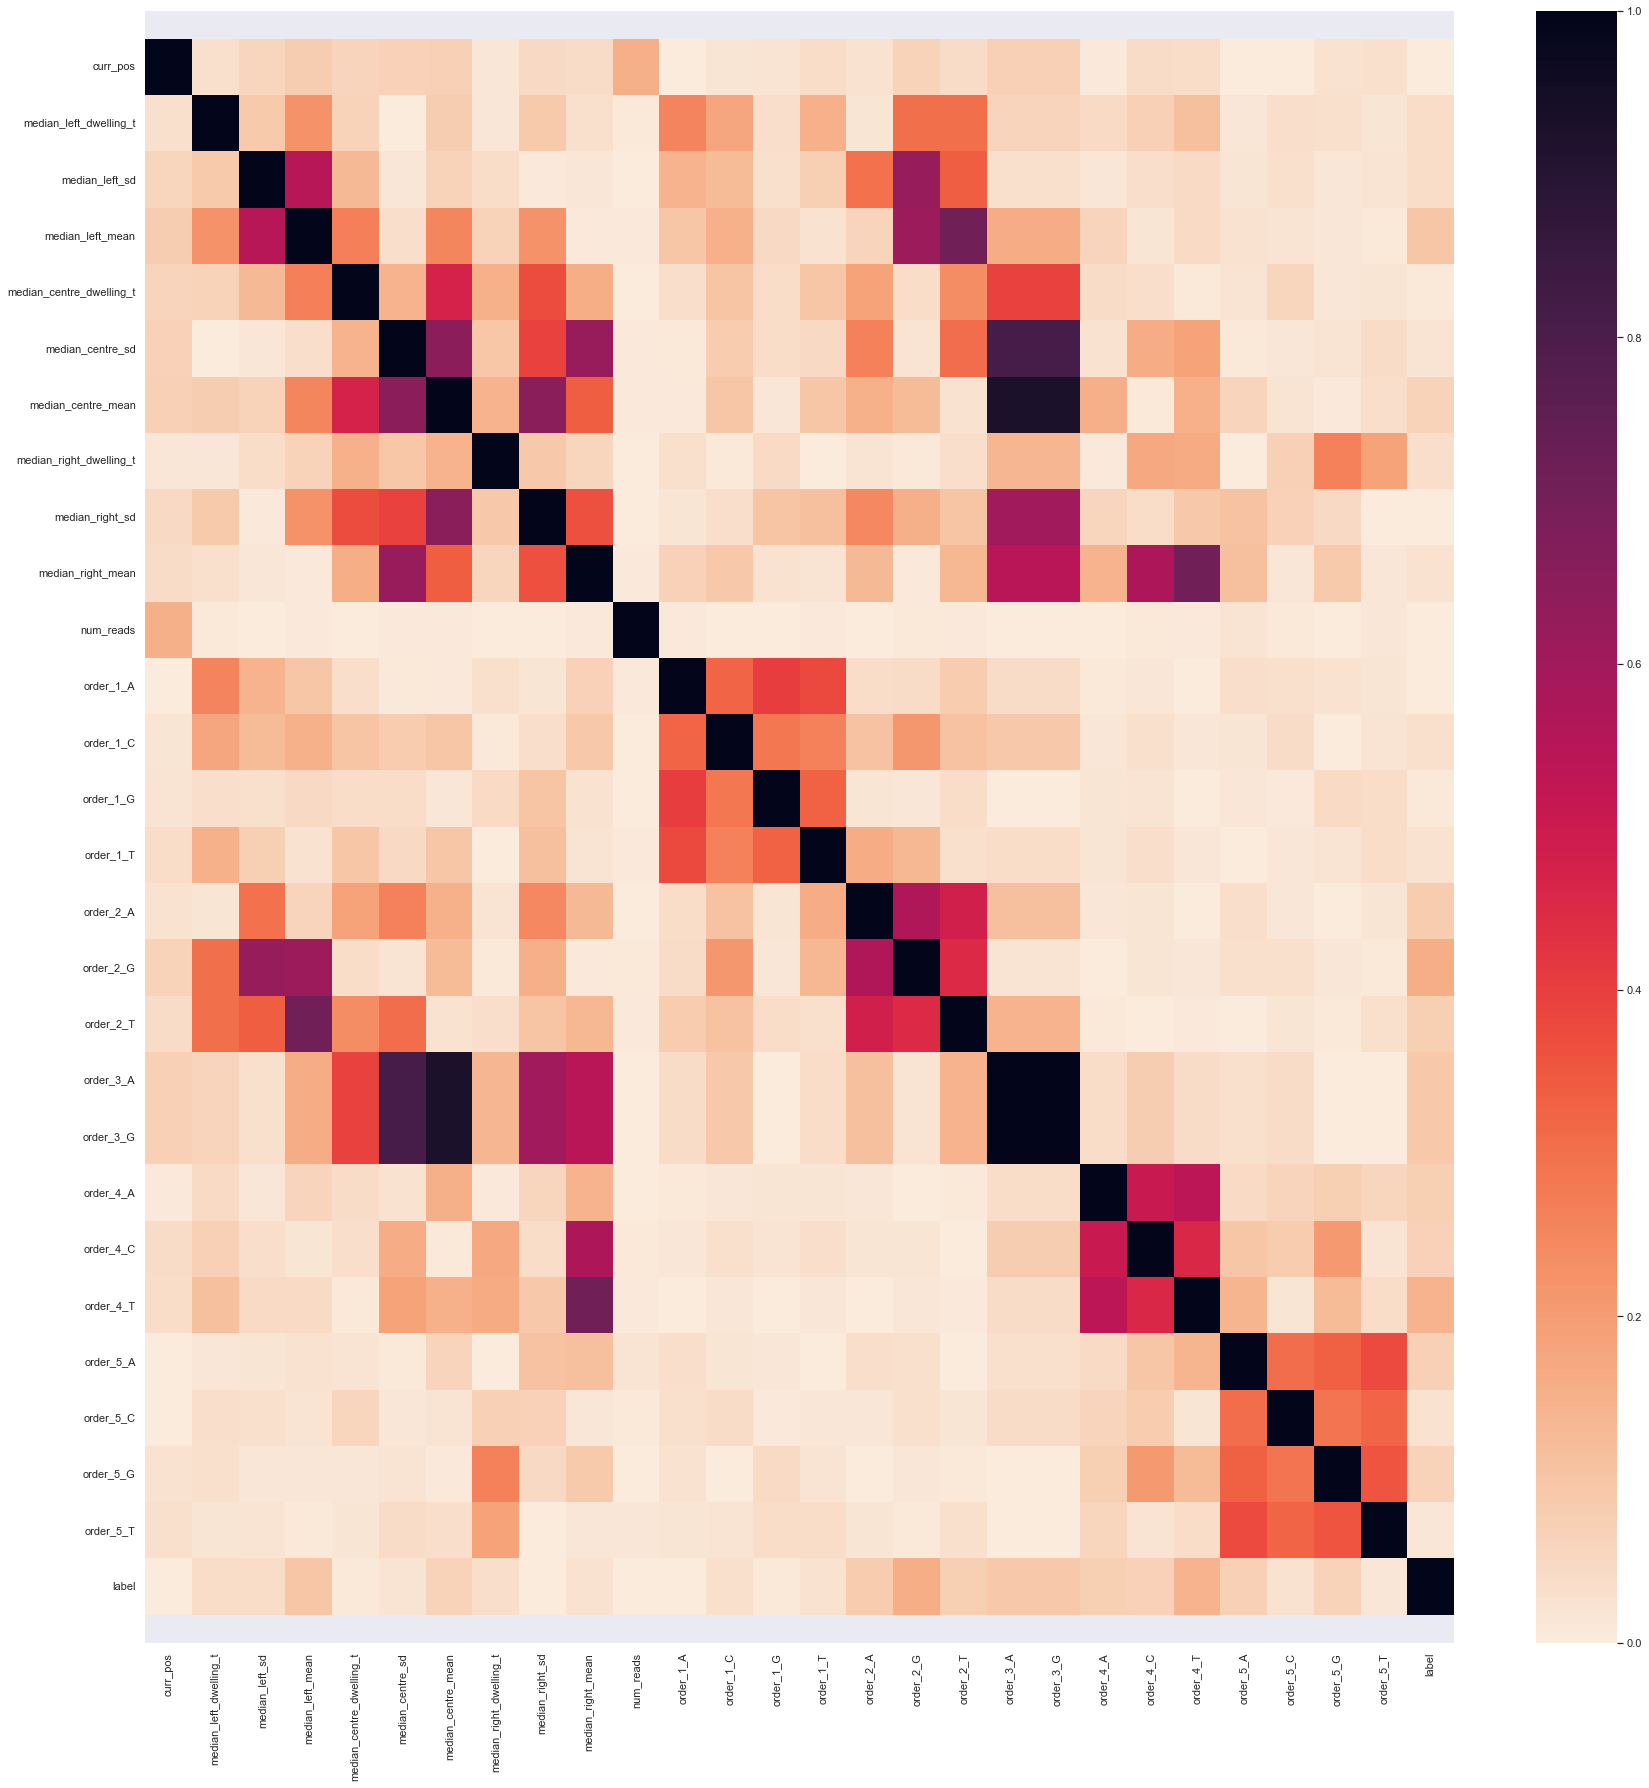

In [19]:
column_names = corr_df.columns.tolist()
corr_dict = cont_dict
corr_lst = []

corr_matrix = np.zeros((len(column_names), len(column_names)))
corr_matrix = pd.DataFrame(corr_matrix, columns = column_names, index = column_names)

def cramers_corrected_stat(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

def correlation_coeff(x, y):
    abs_corr = abs(x.corr(y, method = 'pearson'))
    return abs_corr

for key in corr_dict:
    for key2 in corr_dict:
        if corr_dict[key] == 'continuous' and corr_dict[key2] == 'continuous':
            curr_corr = correlation_coeff(corr_df[key], corr_df[key2])
        elif corr_dict[key] == 'categorical' and corr_dict[key2] == 'continuous':
            curr_corr = correlation_ratio(corr_df[key], corr_df[key2])
        elif corr_dict[key] == 'continuous' and corr_dict[key2] == 'categorical':
            curr_corr = correlation_ratio(corr_df[key2], corr_df[key])
        elif corr_dict[key] == 'categorical' and corr_dict[key2] == 'categorical':
            curr_corr = cramers_corrected_stat(corr_df[key], corr_df[key2])
        corr_matrix[key][key2] = curr_corr

        if curr_corr >= 0.7 and column_names.index(key) < column_names.index(key2):
            corr_lst.append([key, key2, curr_corr])
            print(key + "," + key2 + " " + str(curr_corr))

sns.set(rc={'figure.figsize':(25,25)})
ax = sns.heatmap(corr_matrix,
                 xticklabels = column_names,
                 yticklabels = column_names,
                 vmin = 0,
                 vmax = 1,
                 cmap = sns.cm.rocket_r)

top, bottom = ax.get_ylim()
ax.set_ylim(top + 0.5, bottom - 0.5)
plt.tight_layout()
plt.show()

### Train test split

In [20]:
labels.label.value_counts()[0]/labels.label.value_counts()[1]

21.25351598173516

There are 21 times more zeroes than 1's. 

In [21]:
genes = list(labels['gene_id'].unique())
train_genes, test_genes = train_test_split(genes, train_size = 0.8, random_state=42)
train_labels = labels[labels['gene_id'].isin(train_genes)]
test_labels = labels[labels['gene_id'].isin(test_genes)]
print(f'Imbalance in train labels: {train_labels.label.value_counts()[0]/train_labels.label.value_counts()[1]}')
print(f'Imbalance in test labels: {test_labels.label.value_counts()[0]/test_labels.label.value_counts()[1]}')

Imbalance in train labels: 20.6593603220756
Imbalance in test labels: 23.899402390438247


In [22]:
X_train = pd.merge(train_labels, df3, how='inner',left_on=['gene_id', 'transcript_id', 'transcript_position', 'label'], right_on=['gene_id', 'transcript_id', 'curr_pos', 'label'])
X_test = pd.merge(test_labels, df3, how='inner',left_on=['gene_id','transcript_id', 'transcript_position', 'label'], right_on=['gene_id', 'transcript_id', 'curr_pos', 'label'])

In [23]:
y_train = np.asarray(X_train['label'])
y_test = np.asarray(X_test['label'])

In [24]:
X_test = X_test.drop(['gene_id', 'transcript_id', 'transcript_position','label', 'order'], axis=1)

In [25]:
base_train = X_train.drop(['gene_id', 'transcript_id', 'transcript_position','label', 'order'], axis=1)
base_y_train = y_train

### Let us first get the results of the base training without any hypertuning and feature engineering. 

In [26]:
scaler= MinMaxScaler()
scaled_base_train = scaler.fit_transform(base_train)
scaled_X_test = scaler.transform(X_test)

# instantiate the classifier 
xgb_clf = XGBClassifier()
rf_clf = RandomForestClassifier()
lgbm_clf = LGBMClassifier(max_iter=1000)
dt_clf = DecisionTreeClassifier()
lr_clf = LogisticRegression()


# fit the classifier to the training data
xgb_clf.fit(scaled_base_train, base_y_train)
rf_clf.fit(scaled_base_train, base_y_train)
lgbm_clf.fit(scaled_base_train, base_y_train)
dt_clf.fit(scaled_base_train, base_y_train)
lr_clf.fit(scaled_base_train, base_y_train)

c:\Users\xyber\anaconda3\envs\sanraj1\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] num_iterations is set=1000, max_iter=1000 will be ignored. Current value: num_iterations=1000


c:\Users\xyber\anaconda3\envs\sanraj1\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [27]:
# Get the predicited probability of testing data
xgb_y_score = xgb_clf.predict_proba(scaled_X_test)[:, 1]
rf_y_score = rf_clf.predict_proba(scaled_X_test)[:, 1]
lgbm_y_score = lgbm_clf.predict_proba(scaled_X_test)[:, 1]
dt_y_score = dt_clf.predict_proba(scaled_X_test)[:, 1]
lr_y_score = lr_clf.predict_proba(scaled_X_test)[:, 1]

In [28]:
xgb_y_pred = xgb_clf.predict(scaled_X_test)
rf_y_pred = rf_clf.predict(scaled_X_test)
lgbm_y_pred = lgbm_clf.predict(scaled_X_test)
dt_y_pred = dt_clf.predict(scaled_X_test)
lr_y_pred = lr_clf.predict(scaled_X_test)

Base XGB

In [29]:
print(f"Base line xgb Precision Score: {precision_score(y_test, xgb_y_pred)}")
print(f"Base line xgb Recall Score: {recall_score(y_test, xgb_y_pred)}")
print(f"Base line xgb AUCROC Score: {roc_auc_score(y_test, xgb_y_score)}")
print(f"Base line xgb PR AUC: {average_precision_score(y_test, xgb_y_score)}")

Base line xgb Precision Score: 0.6189516129032258
Base line xgb Recall Score: 0.3057768924302789
Base line xgb AUCROC Score: 0.8841748239382541
Base line xgb PR AUC: 0.42487792765900534


Below code is to plot the PR AUC Curve.

In [ ]:
# # Data to plot precision - recall curve
# precision, recall, thresholds = precision_recall_curve(y_test, xgb_y_score)
# # Use AUC function to calculate the area under the curve of precision recall curve
# auc_precision_recall = auc(recall, precision)
# print(auc_precision_recall)
# plt.plot(recall, precision)
# plt.show()

Base Rf

In [30]:
print(f"Base line rf Precision Score: {precision_score(y_test, rf_y_pred)}")
print(f"Base line rf Recall Score: {recall_score(y_test, rf_y_pred)}")
print(f"Base line rf AUCROC Score: {roc_auc_score(y_test, rf_y_score)}")
print(f"Base line rf PR AUC: {average_precision_score(y_test, rf_y_score)}")

Base line rf Precision Score: 0.7048192771084337
Base line rf Recall Score: 0.23306772908366533
Base line rf AUCROC Score: 0.8766290121863037
Base line rf PR AUC: 0.42080090181445684


Base LGBM

In [31]:
print(f"Base line lgbm Precision Score: {precision_score(y_test, lgbm_y_pred)}")
print(f"Base line lgbm Recall Score: {recall_score(y_test, lgbm_y_pred)}")
print(f"Base line lgbm AUCROC Score: {roc_auc_score(y_test, lgbm_y_score)}")
print(f"Base line lgbm PR AUC: {average_precision_score(y_test, lgbm_y_score)}")

Base line lgbm Precision Score: 0.6129707112970711
Base line lgbm Recall Score: 0.2918326693227092
Base line lgbm AUCROC Score: 0.8767996569670473
Base line lgbm PR AUC: 0.4125025104002921


Base LR

In [32]:
print(f"Base line lr Precision Score: {precision_score(y_test, lr_y_pred)}")
print(f"Base line lr Recall Score: {recall_score(y_test, lr_y_pred)}")
print(f"Base line lr AUCROC Score: {roc_auc_score(y_test, lr_y_score)}")
print(f"Base line lr PR AUC: {average_precision_score(y_test, lr_y_score)}")

Base line lr Precision Score: 0.6601307189542484
Base line lr Recall Score: 0.20119521912350596
Base line lr AUCROC Score: 0.8570013341092808
Base line lr PR AUC: 0.36275826366711306


#### Manual Cross Validation

In [35]:
num_genes = len(train_genes)
validation_set_size = int(.2 * num_genes)
train_indices = np.array([i for i in range(num_genes)])

In [36]:
import random
random.seed(10)

s = list(range(num_genes))
random.shuffle(s)

set1 = s[-validation_set_size:]
del s[-validation_set_size:]

set2 = s[-validation_set_size:]
del s[-validation_set_size:]

set3 = s[-validation_set_size:]
del s[-validation_set_size:]

set4 = s[-validation_set_size:]
del s[-validation_set_size:]

set5 = s

In [37]:
genes_s1 = [train_genes[i] for i in set1]
genes_s2 = [train_genes[i] for i in set2]
genes_s3 = [train_genes[i] for i in set3]
genes_s4 = [train_genes[i] for i in set4]
genes_s5 = [train_genes[i] for i in set5]

In [38]:
s1_train = X_train[X_train['gene_id'].isin(genes_s1)]
s2_train = X_train[X_train['gene_id'].isin(genes_s2)]
s3_train = X_train[X_train['gene_id'].isin(genes_s3)]
s4_train = X_train[X_train['gene_id'].isin(genes_s4)]
s5_train = X_train[X_train['gene_id'].isin(genes_s5)]

In [39]:
s1_train = s1_train.drop(['gene_id', 'transcript_id', 'transcript_position', 'order'], axis=1)
s2_train = s2_train.drop(['gene_id', 'transcript_id', 'transcript_position', 'order'], axis=1)
s3_train = s3_train.drop(['gene_id', 'transcript_id', 'transcript_position', 'order'], axis=1)
s4_train = s4_train.drop(['gene_id', 'transcript_id', 'transcript_position', 'order'], axis=1)
s5_train = s5_train.drop(['gene_id', 'transcript_id', 'transcript_position', 'order'], axis=1)

In [40]:
sets = [s1_train, s2_train, s3_train, s4_train, s5_train]

In [41]:
for datas in sets:
    print(datas.label.value_counts()[0]/datas.label.value_counts()[1])

21.661555312157724
20.399332591768633
21.12316384180791
20.554176072234764
19.53490990990991


In [72]:
def cross_val(model, data):
    precision = 0
    recall = 0
    aucroc = 0
    prauc = 0

    for i in range(5):
        val = data[i]
        y_val = np.asarray(val['label'])
        X_val = val.drop(['label'], axis=1)

        train = pd.concat(data[:i] + data[i+1:], axis=0)
        y_train = np.asarray(train['label'])
        X_train = train.drop(['label'], axis=1)

        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        # define the sampling method
        # undersample = NearMiss(version=1, n_neighbors=3)
        oversample = RandomOverSampler(sampling_strategy='minority')
        X_over, y_over = oversample.fit_resample(X_train_scaled, y_train)

        model.fit(X_over, y_over)
        y_score = model.predict_proba(X_val_scaled)[:, 1]
        y_pred = model.predict(X_val_scaled)

        precision += precision_score(y_val, y_pred)
        recall += recall_score(y_val, y_pred)
        aucroc += roc_auc_score(y_val, y_score)
        prauc += average_precision_score(y_val, y_score)
    
    precision /= 5
    recall /= 5
    aucroc /= 5
    prauc /= 5

    results = {'precision': precision, 'recall': recall, 'aucroc': aucroc, 'prauc': prauc}
    return results

In [73]:
clf = RandomForestClassifier()
cross_val(clf, sets)

{'precision': 0.6416747926789121,
 'recall': 0.2777398288205689,
 'aucroc': 0.8794713821472389,
 'prauc': 0.4190229279902578}

In [48]:
clf2 = RandomForestClassifier(class_weight='balanced')
cross_val(clf2, sets)

{'precision': 0.6746713137012995,
 'recall': 0.17366989767573182,
 'aucroc': 0.8744141564322969,
 'prauc': 0.4128073781887558}

In [49]:
clf3 = RandomForestClassifier(class_weight='balanced_subsample')
cross_val(clf3, sets)

{'precision': 0.6749428429269942,
 'recall': 0.16986103698495417,
 'aucroc': 0.875296891749111,
 'prauc': 0.4127674821090298}

In [59]:
n_estimators = np.linspace(10, 1000, 10)
criterion = ['gini', 'entropy', 'log_loss']
max_depth = np.arange(0, 20, 4)
max_features = ['sqrt', 'log2']
min_samples_split = np.linspace(2, 20, 10)


In [74]:
nest_precision = []
nest_recall = []
for val in n_estimators:
    model = RandomForestClassifier(n_estimators=int(val), class_weight='balanced_subsample', n_jobs=-1)
    res = cross_val(model, sets)
    prec = res['precision']
    rec = res['recall']
    nest_precision.append(prec)
    nest_recall.append(rec)    

KeyboardInterrupt: 

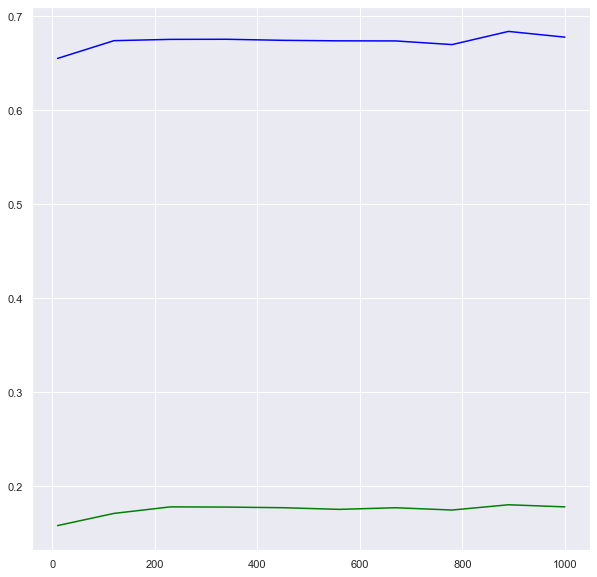

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(n_estimators,nest_precision, c='blue')
plt.plot(n_estimators,nest_recall, c='green')
